# Default of Credit Card Clients - Case Study

This notebook contains:
* Exploratory Data Analysis (EDA) of the taiwan credit card default dataset
* Model development + evaluation

## Table of Contents
- [1. Quick Exploratory Data Analysis](#1-quick-exploratory-data-analysis)
    - [1.1 Reading input data](#11-reading-input-data)
    - [1.2 Summary Statistics](#12-summary-statistics)
    - [1.3 Feature Distributions](#13-feature-distributions)
    - [1.4 Variabel Relashionships](#14-variable-relationships)
- [2. Data Cleaning](#2-data-cleaning)
- [3. Feature Engineering + Building Preprocessing](#3-feature-engineering--building-preprocessing)
- [4. Train Test Split](#4-train-test-split)
- [5. Experiments](#5-experiments)
    - [5.1 Choose Estimator and Run Experiments](#51-choose-estimator-and-run-experiments)
    - [5.2 Experiment results](#52-experiment-results)
- [6. Training best preprocessor estimator combo](#6-tranining-best-preprocessor-estimator-combo)
- [7. Evaluation and Feature Importance](#7-evaluation-and-feature-importance)
    - [7.1 Results](#71-results)
- [8. Store Serialized Model](#8-store-serialized-model)
- [9. Future Improvements](#9-future-improvements)

## 1. Quick Exploratory Data Analysis

### 1.1 Reading input data

To be able to execute this notebook you need to download the dataset from here: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients <br>
After downloading the dataset you need to store it in the same folder as this notebook with the name: `credit_default.xls` <br>

In [1]:
import pandas as pd
import numpy as np
import random

pd.set_option("display.max_rows", 30)

SEED = 5
random.seed(SEED)
np.random.seed(SEED)

df = pd.read_excel("credit_default.xls", header=1)
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [2]:
# Rename the target
raw_target_name = "default payment next month"
target_name = "default"

df = df.rename(columns={raw_target_name: target_name})

### 1.2 Summary Statistics

In [3]:
# Overall dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

No null values found

In [4]:
TARGET_COL = [target_name]
CAT_COLS = ["SEX", "EDUCATION", "MARRIAGE"]
NUMERIC_COLS = [col for col in df.columns if col not in CAT_COLS + ["ID"] + TARGET_COL]

# Turn categorical cols into type category
for col in CAT_COLS + TARGET_COL:
    df[col] = df[col].astype("category")


display(df[CAT_COLS + TARGET_COL].describe().T)

,count,unique,top,freq
SEX,30000,2,2,18112
EDUCATION,30000,7,2,14030
MARRIAGE,30000,4,2,15964
default,30000,2,0,23364


In [5]:
df[NUMERIC_COLS].describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0
PAY_6,30000.0,-0.291100,1.149988,-2.0,-1.00,0.0,0.00,8.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0


In [6]:
df["PAY_0"].value_counts().sort_index()

PAY_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64

After analysing the data up until now, I noticed the following things:
* The outliers in monetary features like **PAY_AMT*** and **BILL_AMT*** are very noticeable, and these features are **right-skewed**. This indicates that a **RobustScaler** could be more effective than a **StandardScaler** during the normalization process usually required if we want to test linear models.
* The **PAY_*** features go from **-2** to **8**, which is different than the expected range of **-1** to **9**.
* **EDUCATION** and **MARRIAGE** also have different values from what is expected.

<br>After further research, I found that these undocumented values have different meanings. So we have two options: 
1. Leave them as they are, accepting the risk of having very few data points from a particular category inside the training data. 
2. "Fix" them by reclassifiying them into one of the already known categories. However these undocumented classes could carry signal.

<br> I will run experiments using both approaches and then compare.

In [7]:
# Checking class balance
class_counts = df["default"].value_counts()

print("Class counts:\n", class_counts)
print("\nRates:\n", class_counts / len(df))

Class counts:
 default
0    23364
1     6636
Name: count, dtype: int64

Rates:
 default
0    0.7788
1    0.2212
Name: count, dtype: float64


The target column is imbalanced, which is expected since defaults are rare.

### 1.3 Feature distributions

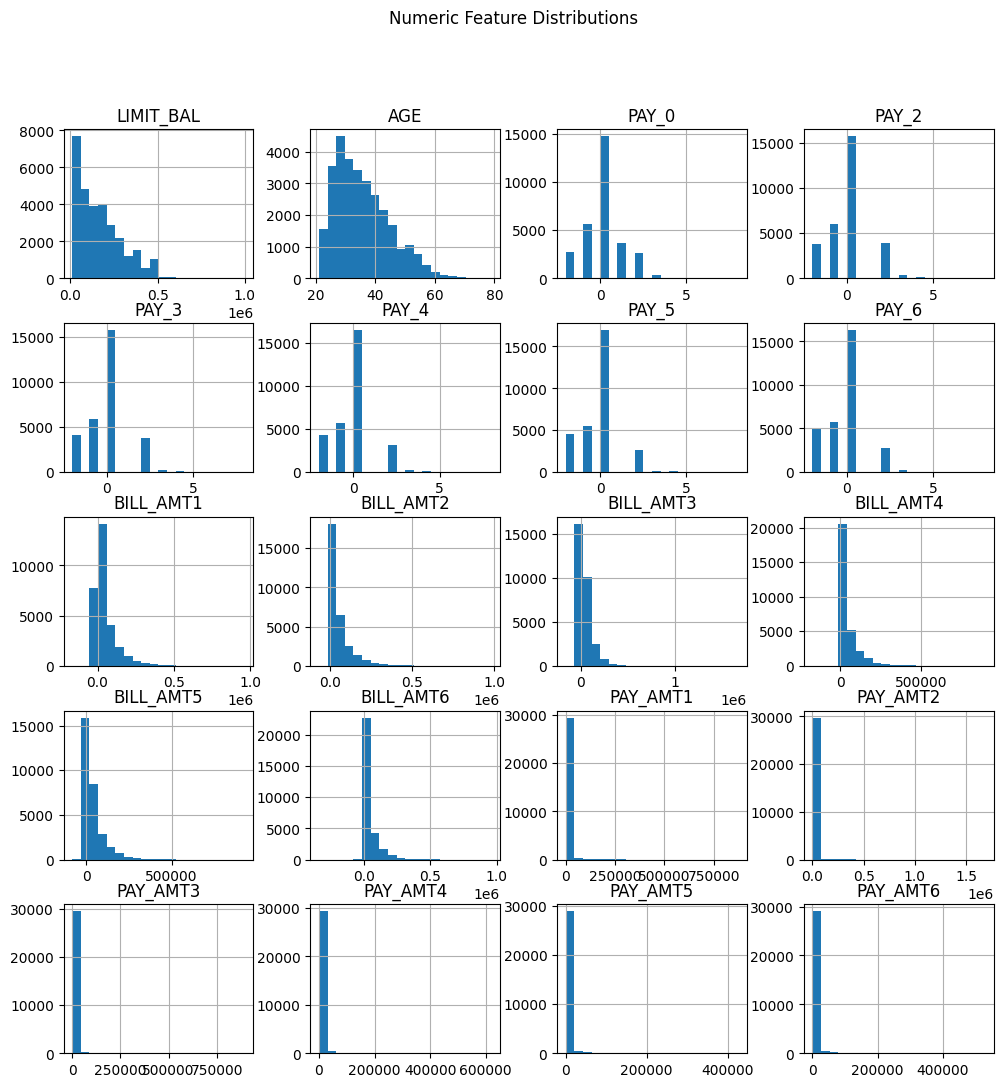

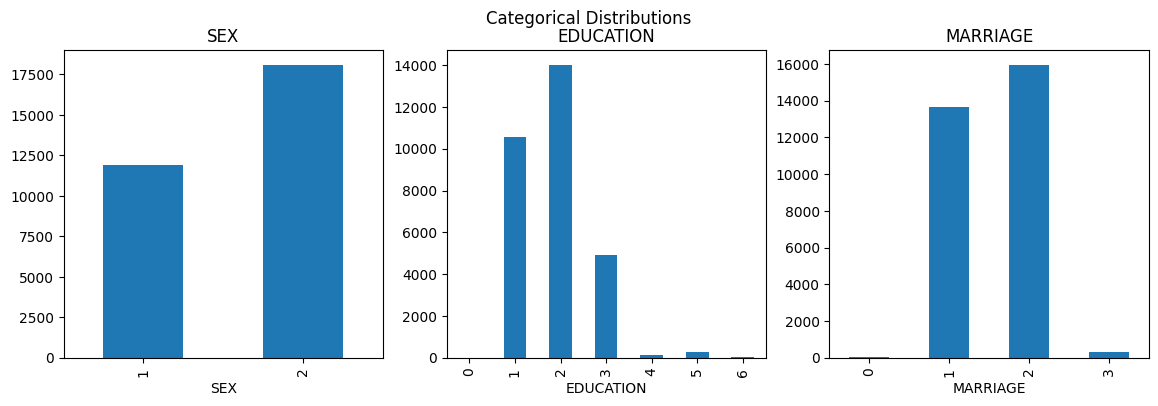

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df[NUMERIC_COLS].hist(bins=20, figsize=(12, 12))
plt.suptitle("Numeric Feature Distributions")
plt.show()


fig, axes = plt.subplots(1, len(CAT_COLS), figsize=(14, 4))
for ax, col in zip(axes, CAT_COLS):
    df[col].value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set_title(col)
plt.suptitle("Categorical Distributions")
plt.show()

These distribution plots confirm the earlier findings that the monetary features are right-skewed, and most payment amounts are zero.

### 1.4 Variable relationships

In [9]:
# Correlation with target
corrs = (
    df[CAT_COLS + NUMERIC_COLS + TARGET_COL]
    .corr()[target_name]
    .drop(target_name)
    .sort_values(ascending=False)
)
corrs.to_frame("corr_with_default")

,corr_with_default
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
EDUCATION,0.028006
AGE,0.013890
BILL_AMT6,-0.005372
BILL_AMT5,-0.006760


Mostly negligible correlations. Feature PAY_0 is the only one with a small but meningful correlation.

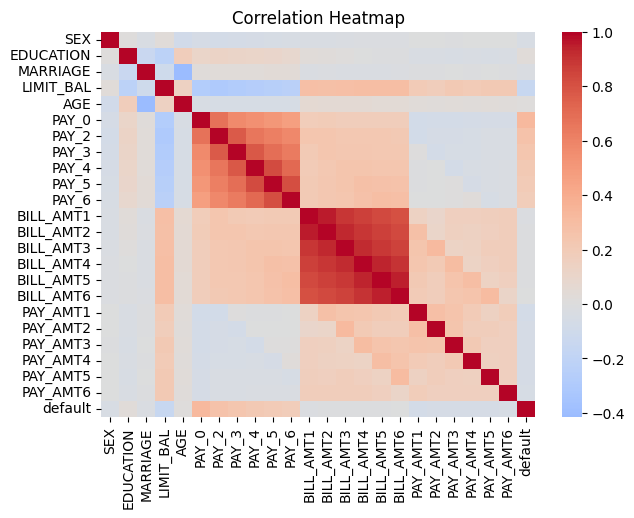

In [10]:
corrs = df[CAT_COLS + NUMERIC_COLS + TARGET_COL].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corrs, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

The very high correlation between **BILL_AMT*** columns indicates **multicollinearity**, which can hurt linear models.

## 2. Data Cleaning

In [11]:
df_clean = df.copy()

# Drop id column
df_clean = df_clean.drop(columns=["ID"])

# Check for duplicates
before = len(df_clean)
print(f"Before dropping duplicates: {before}")

df_clean = df_clean.drop_duplicates()

after = len(df_clean)
print(f"After dropping duplicates: {len(df_clean)}")
print(f"{before - after} duplicate rows removed")

Before dropping duplicates: 30000
After dropping duplicates: 29965
35 duplicate rows removed


## 3. Feature Engineering + Building Preprocessing

### 3.1 Preprocessing steps

The following transformers will be added to the **pipeline** as **steps**, which will be serialized with the chosen model in the end.

In [12]:
from typing import Optional
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureFixer(BaseEstimator, TransformerMixin):
    """
    Fixer to map:
    * PAY_* {-2} -> -1
    """

    def __init__(self, pay_cols: list[str], cap_months: Optional[int] = 6):
        self.pay_cols = pay_cols
        self.cap_months = cap_months

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Only fix PAY_* values: -2 -> -1
        for c in self.pay_cols:
            if c not in X.columns:
                continue

            s = pd.Series(X[c]).astype("int64")
            s = s.replace({-2: -1})

            if self.cap_months is not None:
                s = s.clip(upper=self.cap_months)

            X[c] = s

        return X
    
    def set_output(self, *, transform=None):
        return self

In [13]:
class MonthlyAggregator(BaseEstimator, TransformerMixin):
    """
    Build compact aggregates and drop the monthly columns.
    Except PAY_0.
    """

    def __init__(
        self,
        pay_cols: list[str],
        bill_cols: list[str],
        pay_amt_cols: list[str],
        drop_original=True,
    ):
        self.pay_cols = pay_cols
        self.bill_cols = bill_cols
        self.pay_amt_cols = pay_amt_cols
        self.drop_original = drop_original
        self.out_cols = [
            "has_any_delay",
            "pay_delay_count",
            "bill_amt_sum",
            "pay_amt_sum",
            "pct_left_to_pay",
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        pay = X[self.pay_cols]
        bills = X[self.bill_cols]
        pays = X[self.pay_amt_cols]

        # has_any_delay = 1 if any PAY_* > 0 else 0
        has_any_delay = (pay.values > 0).any(axis=1)

        # pay_delay_count = number of months with PAY_* > 0
        pay_delay_count = (pay.values > 0).sum(axis=1)

        # bill_amt_sum = sum of BILL_AMT1 to BILL_AMT6
        bill_amt_sum = bills.sum(axis=1)

        # pay_amt_sum = sum of PAY_AMT1 to PAY_AMT6
        pay_amt_sum = pays.sum(axis=1)

        # pct_left_to_pay = max(0, (bill_amt_sum - pay_amt_sum) / (bill_amt_sum + 1e-6))
        pct_left_to_pay = np.maximum(
            0.0, (bill_amt_sum - pay_amt_sum) / (bill_amt_sum + 1e-6)
        )

        X["has_any_delay"] = has_any_delay
        X["pay_delay_count"] = pay_delay_count
        X["bill_amt_sum"] = bill_amt_sum
        X["pay_amt_sum"] = pay_amt_sum
        X["pct_left_to_pay"] = pct_left_to_pay

        if self.drop_original:
            pay_cols = self.pay_cols.copy()
            pay_cols.remove("PAY_0")
            X = X.drop(columns=(pay_cols + self.bill_cols + self.pay_amt_cols))

        return X

    def set_output(self, *, transform=None):
        return self

In [14]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drop specified columns"""

    def __init__(self, to_drop: list[str]):
        self.to_drop = to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=[c for c in self.to_drop if c in X.columns])

    def set_output(self, *, transform=None):
        return self

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
)
from sklearn.compose import ColumnTransformer


def discover_columns(df: pd.DataFrame, target: str = "default"):
    """
    Discover feature groups and compute a strict whitelist of allowed columns.
    Only keep known, non-sensitive features; drop everything else.
    """
    pay_cols = [c for c in [f"PAY_{i}" for i in range(0, 7)] if c in df.columns]
    bill_cols = [c for c in [f"BILL_AMT{i}" for i in range(1, 7)] if c in df.columns]
    pay_amt_cols = [c for c in [f"PAY_AMT{i}" for i in range(1, 7)] if c in df.columns]

    # Allowing only the known monthly features and BAL
    base_allowed = list(dict.fromkeys(pay_cols + bill_cols + pay_amt_cols + ["LIMIT_BAL"]))
    allowed = [c for c in base_allowed if c in df.columns]
    to_drop = [c for c in df.columns if c not in allowed]

    return {
        "target": [target],
        "pay_cols": pay_cols,
        "bill_cols": bill_cols,
        "pay_amt_cols": pay_amt_cols,
        "allowed": allowed,
        "to_drop": to_drop,
    }


def build_preprocessor(
    df_sample: pd.DataFrame,
    model_kind: str = "lr",
    apply_fixes: bool = False,
    drop_original: bool = False,
    aggregate: bool = False,
    scaler: str = "robust",
) -> Pipeline:
    """
    Build the preprocessor object to be serialized with the model.
    """

    columns = discover_columns(df_sample)

    steps = []

    # Drop everything NOT explicitly allowed
    steps = [("drop_cols", ColumnDropper(columns["to_drop"]))]

    if apply_fixes:
        steps.append(
            ("fixes", FeatureFixer(pay_cols=columns["pay_cols"], cap_months=6))
        )

    cat_cols = []
    if aggregate:
        steps.append(
            (
                "aggregate",
                MonthlyAggregator(
                    pay_cols=columns["pay_cols"],
                    pay_amt_cols=columns["pay_amt_cols"],
                    bill_cols=columns["bill_cols"],
                    drop_original=drop_original,
                ),
            )
        )
        cat_cols += ["has_any_delay", "pay_delay_count"]
        if drop_original and "PAY_0" in df_sample.columns:
            cat_cols = cat_cols + ["PAY_0"]

    if not aggregate or (aggregate and not drop_original):
        cat_cols += columns["pay_cols"]

    if model_kind == "lr":
        # Choosing the scaler
        scaler_obj = RobustScaler() if scaler == "robust" else StandardScaler()

        # Exclude columns that MonthlyAggregator will drop
        drop_after_agg = set()
        if aggregate and drop_original:
            drop_after_agg = set(
                columns["pay_cols"] + columns["bill_cols"] + columns["pay_amt_cols"]
            )
            drop_after_agg.discard("PAY_0")  # keep PAY_0

        num_cols = [
            c
            for c in df_sample.columns
            if (c not in cat_cols)
            and (c not in drop_after_agg)
            and pd.api.types.is_numeric_dtype(df_sample[c])
            and (c in columns["allowed"])
        ]

        ct = ColumnTransformer(
            transformers=[
                (
                    "cat",
                    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    cat_cols,
                ),
                ("num", scaler_obj, num_cols),
            ],
            remainder="drop",
        )
        steps.append(("columns", ct))
        return Pipeline(steps=steps)

    elif model_kind == "tree":

        # Ordinal encode categorical features and passthrough numerics
        ct_tree = ColumnTransformer(
            transformers=[
                (
                    "cat",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value", unknown_value=-1
                    ),
                    cat_cols,
                ),
            ],
            remainder="passthrough",
        )
        steps.append(("encode", ct_tree))

    # No encoding and no scaling for tree-based models
    return Pipeline(steps=steps)

Above is the function `build_preprocessor`, which is responsible for creating our preprocessing pipeline. This pipeline transforms the raw features into what the model expects to receive. In the experiments section below, I show clearly which steps are combined in each experiment.

The experiment steps are:
1. **ColumnDropper** (required) -> Drop columns such as ID, default, SEX, AGE, EDUCATION, MARRIAGE, and any others that are not known features
2. **FeatureFixer** (optional) -> Fix features with undocumented values in PAY_* (e.g., map -2 to -1)
3. **MonthlyAggregator** (optional) -> Create engineered features by aggregating the monthly features (PAY_*, PAY_AMT*, BILL_AMT*). This step has a parameter to drop the old columns after the aggregation
4. **OneHotEncoder** (required for Logistic Regression) -> Apply one-hot encoding to categorical variables such as PAY_*
5. **OrdinalEncoder** (required for Random Forest) -> Apply ordinal encoding to categorical variables such as PAY_*

## 4. Train Test Split

We split the data into stratified train and test sets to preserve the target distribution.

In [16]:
from sklearn.model_selection import train_test_split

columns = discover_columns(df_clean)
target = columns["target"]

if "ID" in df_clean.columns.values:
    X_all = df_clean.drop(columns=["ID"] + target)
X_all = df_clean.drop(columns=target)

y_all = df_clean[target[0]].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all
)

print(f"Shape of training data: {X_train.shape}")

Shape of training data: (23972, 23)


## 5. Experiments

I chose to make **15 experiments**, **5** for each model, to find the best combination of model and preprocessing strategy. Also to test if it is possible to use **a subset of the provided variables** to create the model, without **substantial reduction in the performance** of the model.
<br>
Some experiments include **engineered features**. They are aggregations of the **monthly features** and their purpose is to **reduce dimensionality** while retaining the most relevant information, and ideally to improve the model. An important thing to notice is that for all experiments the column **PAY_0** was kept because of its **high prediction power** and decent **correlation with the target**.

<br>Experiments:
1. All features, no fixes, and no engineered features.
2. All features, no fixes, plus engineered features.
3. All features with fixes and engineered features.
4. Fixed features, replacing monthly variables with their aggregated counterparts.
5. No fixes, replacing monthly variables with their aggregated counterparts.

The **Logistic Regression** model uses **One Hot Encode** for categorical features while the **tree-based** models use **Ordinal Encode**

In [17]:
# LOGISTIC REGRESSION (with OHE, with scaling)
# For Logistic Regression (OHE path)
LR_EXPERIMENTS = [
    (
        "LR | ALL (no fixes, no agg)",
        dict(aggregate=False, drop_original=False, apply_fixes=False, model_kind="lr"),
    ),
    (
        "LR | ALL + AGG (no fixes)",
        dict(aggregate=True, drop_original=False, apply_fixes=False, model_kind="lr"),
    ),
    (
        "LR | ALL + AGG (fixes)",
        dict(aggregate=True, drop_original=False, apply_fixes=True, model_kind="lr"),
    ),
    (
        "LR | AGG ONLY (fixes)",
        dict(aggregate=True, drop_original=True, apply_fixes=True, model_kind="lr"),
    ),
    (
        "LR | AGG ONLY (no fixes)",
        dict(aggregate=True, drop_original=True, apply_fixes=False, model_kind="lr"),
    ),
]

# For Tree models (no encoding, no scaling)
TREE_EXPERIMENTS = [
    (
        "TREE | ALL (no fixes, no agg)",
        dict(
            aggregate=False, drop_original=False, apply_fixes=False, model_kind="tree"
        ),
    ),
    (
        "TREE | ALL + AGG (no fixes)",
        dict(aggregate=True, drop_original=False, apply_fixes=False, model_kind="tree"),
    ),
    (
        "TREE | ALL + AGG (fixes)",
        dict(aggregate=True, drop_original=False, apply_fixes=True, model_kind="tree"),
    ),
    (
        "TREE | AGG ONLY (fixes)",
        dict(aggregate=True, drop_original=True, apply_fixes=True, model_kind="tree"),
    ),
    (
        "TREE | AGG ONLY (no fixes)",
        dict(aggregate=True, drop_original=True, apply_fixes=False, model_kind="tree"),
    ),
]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


def make_estimator(kind: str = "lr", *, random_state: int = SEED, **kwargs):
    """
    Create an estimator object with the given parameters.
    """
    if kind == "lr":
        return LogisticRegression(
            max_iter=1000, class_weight="balanced", random_state=random_state, **kwargs
        )

    elif kind == "rf":
        return RandomForestClassifier(
            n_estimators=200,
            criterion="log_loss",
            max_depth=6,
            class_weight="balanced",
            n_jobs=1,
            random_state=random_state,
            **kwargs,
        )

    elif kind in ("cat", "catboost"):

        params = dict(
            iterations=200,
            depth=6,
            learning_rate=0.06,
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=random_state,
            verbose=False,
            allow_writing_files=False,
        )

        params.update(kwargs)
        return CatBoostClassifier(**params)

    else:
        raise ValueError(f"Unknown estimator: '{kind}'")

### 5.1 Choose estimator and run experiments

In [19]:
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)


def train_and_evaluate(
    pipeline,
    X_train,
    y_train,
    X_test,
    y_test,
    cv_splits: int = 5,
    threshold: float = 0.5,
):
    """
    Train and evaluate a pipeline using Stratified K-Fold cross-validation
    and a final hold-out test set.
    """
    cv = StratifiedKFold(
        n_splits=cv_splits,
        shuffle=True,
        random_state=SEED,
    )

    cv_auc, cv_ap, cv_prec, cv_rec, cv_f1 = [], [], [], [], []

    # Cross-validation loop

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        proba_val = pipeline.predict_proba(X_val)[:, 1]
        y_pred_val = (proba_val >= threshold).astype(int)

        cv_auc.append(roc_auc_score(y_val, proba_val))
        cv_ap.append(average_precision_score(y_val, proba_val))
        cv_prec.append(precision_score(y_val, y_pred_val))
        cv_rec.append(recall_score(y_val, y_pred_val))
        cv_f1.append(f1_score(y_val, y_pred_val))

    # Fit on full train and evaluate on test
    pipeline.fit(X_train, y_train)
    proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (proba_test >= threshold).astype(int)

    # Count number of features after transform
    try:
        pre = pipeline.named_steps["preprocess"]
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", message="This Pipeline instance is not fitted yet"
            )
            Xt_sample = pre.transform(X_train.iloc[:5])
        n_features = (
            Xt_sample.shape[1]
            if hasattr(Xt_sample, "shape")
            else np.asarray(Xt_sample).shape[1]
        )
    except Exception:
        n_features = X_train.shape[1]

    metrics = {
        "n_features": int(n_features),
        # Cross-validation means + stds
        "cv_auc_mean": float(np.mean(cv_auc)),
        "cv_auc_std": float(np.std(cv_auc)),
        "cv_ap_mean": float(np.mean(cv_ap)),
        "cv_ap_std": float(np.std(cv_ap)),
        "cv_prec_mean": float(np.mean(cv_prec)),
        "cv_prec_std": float(np.std(cv_prec)),
        "cv_rec_mean": float(np.mean(cv_rec)),
        "cv_rec_std": float(np.std(cv_rec)),
        "cv_f1_mean": float(np.mean(cv_f1)),
        "cv_f1_std": float(np.std(cv_f1)),
        # Test metrics
        "test_auc": float(roc_auc_score(y_test, proba_test)),
        "test_ap": float(average_precision_score(y_test, proba_test)),
        "test_prec": float(precision_score(y_test, y_pred_test)),
        "test_rec": float(recall_score(y_test, y_pred_test)),
        "test_f1": float(f1_score(y_test, y_pred_test)),
    }

    return metrics


def pretty_print_results(label: str, metrics: dict) -> None:
    """
    Format and prints evaluation metrics
    """
    print(f"\n[{label}]  |  features: {metrics['n_features']}")
    print(
        "CV    "
        f"AUC {metrics['cv_auc_mean']:.4f} ± {metrics['cv_auc_std']:.4f} | "
        f"AP {metrics['cv_ap_mean']:.4f} ± {metrics['cv_ap_std']:.4f} | "
        f"Prec {metrics['cv_prec_mean']:.4f} ± {metrics['cv_prec_std']:.4f} | "
        f"Rec {metrics['cv_rec_mean']:.4f} ± {metrics['cv_rec_std']:.4f} | "
        f"F1 {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}"
    )
    print(
        "TEST  "
        f"AUC {metrics['test_auc']:.4f} | "
        f"AP {metrics['test_ap']:.4f} | "
        f"Prec {metrics['test_prec']:.4f} | "
        f"Rec {metrics['test_rec']:.4f} | "
        f"F1 {metrics['test_f1']:.4f}"
    )

In [20]:
# Scale the weight of default for cat_boost
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = float(neg) / float(pos)


def run_suite(model_kind: str, exp_list, estimator_kwargs=None):
    print(f"\n=== {model_kind.upper()} ===")
    results = {}
    estimator_kwargs = estimator_kwargs or {}
    for tag, cfg in exp_list:
        pre = build_preprocessor(df_clean, **cfg, scaler="robust")
        if model_kind in ("cat", "catboost"):
            est = make_estimator(
                model_kind, **{"scale_pos_weight": scale_pos_weight, **estimator_kwargs}
            )
        else:
            est = make_estimator(model_kind, **estimator_kwargs)
        pipe = Pipeline(steps=[("preprocess", pre), ("model", est)])
        m = train_and_evaluate(pipe, X_train, y_train, X_test, y_test, cv_splits=5)
        results[tag] = (pipe, m)
        pretty_print_results(tag, m)
    return results


results_lr = run_suite("lr", LR_EXPERIMENTS)
results_rf = run_suite("rf", TREE_EXPERIMENTS)
results_cat = run_suite("cat", TREE_EXPERIMENTS)


=== LR ===

[LR | ALL (no fixes, no agg)]  |  features: 77
CV    AUC 0.7661 ± 0.0074 | AP 0.5375 ± 0.0129 | Prec 0.4991 ± 0.0131 | Rec 0.5743 ± 0.0110 | F1 0.5339 ± 0.0095
TEST  AUC 0.7716 | AP 0.5344 | Prec 0.4997 | Rec 0.5716 | F1 0.5332

[LR | ALL + AGG (no fixes)]  |  features: 86
CV    AUC 0.7680 ± 0.0075 | AP 0.5401 ± 0.0132 | Prec 0.4692 ± 0.0116 | Rec 0.6080 ± 0.0134 | F1 0.5296 ± 0.0109
TEST  AUC 0.7742 | AP 0.5336 | Prec 0.4714 | Rec 0.5913 | F1 0.5246

[LR | ALL + AGG (fixes)]  |  features: 68
CV    AUC 0.7674 ± 0.0070 | AP 0.5401 ± 0.0133 | Prec 0.4667 ± 0.0102 | Rec 0.6071 ± 0.0139 | F1 0.5277 ± 0.0103
TEST  AUC 0.7763 | AP 0.5348 | Prec 0.4657 | Rec 0.5943 | F1 0.5222

[LR | AGG ONLY (fixes)]  |  features: 18
CV    AUC 0.7599 ± 0.0070 | AP 0.5338 ± 0.0105 | Prec 0.4566 ± 0.0096 | Rec 0.6146 ± 0.0164 | F1 0.5240 ± 0.0117
TEST  AUC 0.7656 | AP 0.5401 | Prec 0.4612 | Rec 0.6146 | F1 0.5270

[LR | AGG ONLY (no fixes)]  |  features: 21
CV    AUC 0.7598 ± 0.0069 | AP 0.5343 ± 

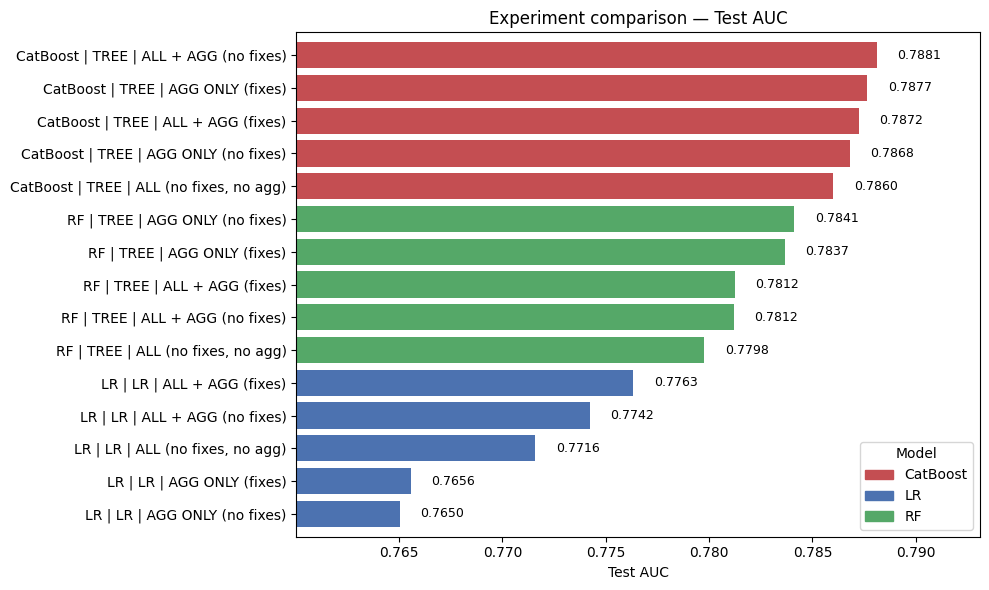

In [21]:
def collect_results(*model_result_dicts):
    """
    Collect and merge the experiment results.
    """
    rows = []
    for d in model_result_dicts:
        for label, (pipe, m) in d.items():
            pre = pipe.named_steps.get("preprocess", None)
            n_feats = getattr(pre, "n_output_features_", m.get("n_features", None))

            est = pipe.named_steps.get("model")
            cls = est.__class__.__name__ if est is not None else "Unknown"
            if "RandomForest" in cls:
                algo = "RF"
            elif "CatBoost" in cls:
                algo = "CatBoost"
            elif "LogisticRegression" in cls:
                algo = "LR"
            else:
                algo = cls

            rows.append(
                {
                    "label": label,
                    "algo": algo,
                    "test_auc": m["test_auc"],
                    "test_ap": m["test_ap"],
                    "test_f1": m["test_f1"],
                    "n_features": n_feats,
                }
            )
    return pd.DataFrame(rows)


results = collect_results(results_lr, results_rf, results_cat)

results["label_unique"] = results["algo"] + " | " + results["label"]

# Order by AUC
df_plot = results.sort_values("test_auc", ascending=False)

# Color by algo
import matplotlib.patches as mpatches

colors = {"LR": "#4C72B0", "RF": "#55A868", "CatBoost": "#C44E52"}
bar_colors = df_plot["algo"].map(colors).fillna("#999999")

plt.figure(figsize=(10, 6))
bars = plt.barh(df_plot["label_unique"], df_plot["test_auc"], color=bar_colors)

plt.xlabel("Test AUC")
plt.title("Experiment comparison — Test AUC")

# Show numeric values
for bar in bars:
    w = bar.get_width()
    plt.text(
        w + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"{w:.4f}",
        va="center",
        fontsize=9,
    )

# Put best at the top
plt.gca().invert_yaxis()

# Legend
handles = [
    mpatches.Patch(color=colors[k], label=k) for k in sorted(df_plot["algo"].unique())
]
plt.legend(handles=handles, title="Model")

plt.xlim(df_plot["test_auc"].min() - 0.005, df_plot["test_auc"].max() + 0.005)
plt.gca().margins(y=0.02)
plt.tight_layout()
plt.show()

### 5.2 Experiment Results

Results are tighter than I expected. With almost no hyper-parameter tuning, **tree-based models** beat LR by a small but consistent margin. I picked **AUC** for model selection (threshold-free, good for ranking). I also tracked **AP, Precision/Recall**, and **F1** at ~0.5 just to sanity-check behavior.

#### **Best runs**

* **CatBoost | ALL + AGG (no fixes)** → **AUC 0.7881**, AP 0.5551, F1 0.5391, **24 features**.
* **CatBoost | AGG ONLY (fixes)** → **AUC 0.7877**, AP 0.5580, F1 0.5394, **7 features**.
* **Best Random Forest | AGG ONLY (no fixes)** → **AUC 0.7841**, AP 0.5563, F1 0.5376, **24 features**.
* **Best LR | ALL + AGG (fixes)** → **AUC 0.7763**, AP 0.5348, F1 0.5222, **68 features**.

**Takeaways**: CatBoost > RF > LR; Aggregates help; “Fixes” added insignificant value.

#### **Which model should we ship?**

* **If we consider the highest score**: CatBoost ALL + AGG (no fixes) — AUC **0.7881**.

* **My pick**: CatBoost | AGG ONLY (fixes) — **AUC 0.7877** with only 7 features and an insignificant difference from the first place.


#### **What to try next**

* **Tiny grid searches**: RF (n_estimators, max_depth, min_samples_leaf), CatBoost (iterations, l2_leaf_reg, learning_rate). A small tuning can squeeze out a few extra AUC points
* **More aggregates**: Try adding simple statistic features like max, mean, and min of the BILL_AMT* and PAY_AMT* features
* **Different models**: Experiment with LightGBM or small Neural Networks to see if they surpass our current results.
* **See what others are doing**: Since this is a public dataset, we can also take a peek on what kinds of models and preprocessing steps worked better for others 

#### **Answer to question 1.a**:
As we can see in the experiment results we were able to **reduce the original number of variables** from **23** down to **7** while **keeping the same consistent performance**. The difference between the best model and the **CatBoost | AGG ONLY (fixes)** is **0.0004**, this is lower than the standard deviation of the cross validation.

### 6. Tranining best preprocessor estimator combo

Now that we chose the pipeline + model we are going to use, let's fit the model in our **full training dataset**. After that, we’ll **calibrate the model’s probabilities** because we’re going to use the score as an actual risk estimate (e.g., “0.31 = 31% default”). Tree models like CatBoost are great rankers (good AUC) but their raw scores are often miscalibrated, especially on imbalanced data. That is why I am using isotonic calibration, to get a more **honest probability**.

A drop in AUC is expected after calibration

In [22]:
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# Build the final preprocessing + CAT (AGG ONLY, with fixes)
pre_template = build_preprocessor(
    df_sample=X_train,
    model_kind="tree",
    apply_fixes=True,
    aggregate=True,
    drop_original=True,
)

model_template = make_estimator(kind="cat", random_state=SEED)

pipe_template = Pipeline(
    [
        ("preprocess", pre_template),
        ("model", model_template),
    ]
)

# Fit a copy on FULL TRAIN dataset for feature importance (un-calibrated)
pipe_fi = clone(pipe_template)
pipe_fi.named_steps["preprocess"].set_output(transform="pandas")
pipe_fi.fit(X_train, y_train)

# Calibrate the pipeline with CV (isotonic). This refits K clones internally, avoiding leakage.
calibrated = CalibratedClassifierCV(estimator=pipe_template, cv=5, method="isotonic")
calibrated.fit(X_train, y_train)

,estimator,Pipeline(step...705F87EC30>)])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,steps,"[('drop_cols', ...), ('fixes', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,to_drop,"['SEX', 'EDUCATION', ...]"
,pay_cols,"['PAY_0', 'PAY_2', ...]"


### 7. Evaluation and Feature Importance

Final CAT (AGG ONLY, fixes) — CALIBRATED results
test_auc: 0.7871
test_ap: 0.5599
test_brier: 0.1341
test_prec: 0.5434
test_rec: 0.5385
test_f1: 0.5409
threshold: 0.2982


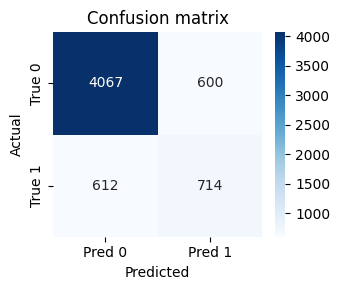

In [23]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    confusion_matrix,
    brier_score_loss,
)

# Pick a decision threshold on TRAIN maximizing F1
p_train = calibrated.predict_proba(X_train)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, p_train)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = float(thr[best_idx])

# Evaluate on TEST dataset with the chosen threshold
p_test = calibrated.predict_proba(X_test)[:, 1]
y_hat = (p_test >= best_thr).astype(int)

metrics = {
    "test_auc": float(roc_auc_score(y_test, p_test)),
    "test_ap": float(average_precision_score(y_test, p_test)),
    "test_brier": float(brier_score_loss(y_test, p_test)),
    "test_prec": float(precision_score(y_test, y_hat)),
    "test_rec": float(recall_score(y_test, y_hat)),
    "test_f1": float(f1_score(y_test, y_hat)),
    "threshold": best_thr,
}

print("Final CAT (AGG ONLY, fixes) — CALIBRATED results")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

cm = confusion_matrix(y_test, y_hat, labels=[0, 1])

plt.figure(figsize=(3.5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

#### 7.1 Results

#### Answer to question 1.c:

The calibrated model achieves **AUC 0.7871** and **AP 0.5599**. A Brier score 0.1341 indicates well-calibrated probabilities, so scores reflect true default risk. With the validation-selected threshold **0.2982**, it yields **Precision 0.5434**, **Recall 0.5385**, and **F1 0.5409**, balancing missed defaulters and false positives. Overall, results align with baselines for this dataset and provide reliable ranking plus actionable probabilities for downstream decisions.

It’s worth noting the dataset is limited and we applied minimal fine-tuning, so there’s still room for improvement.

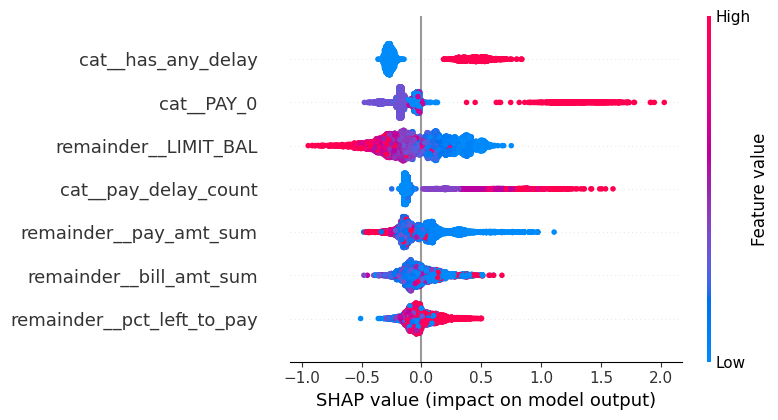

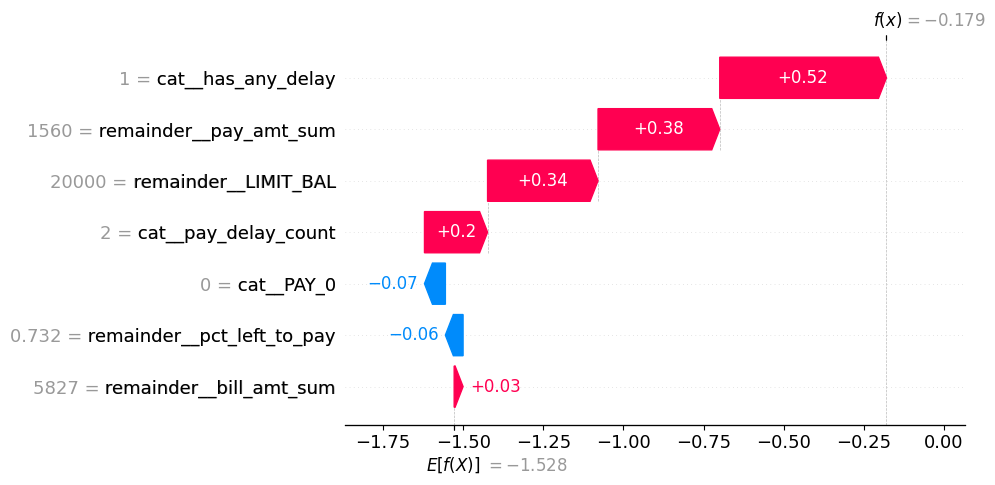

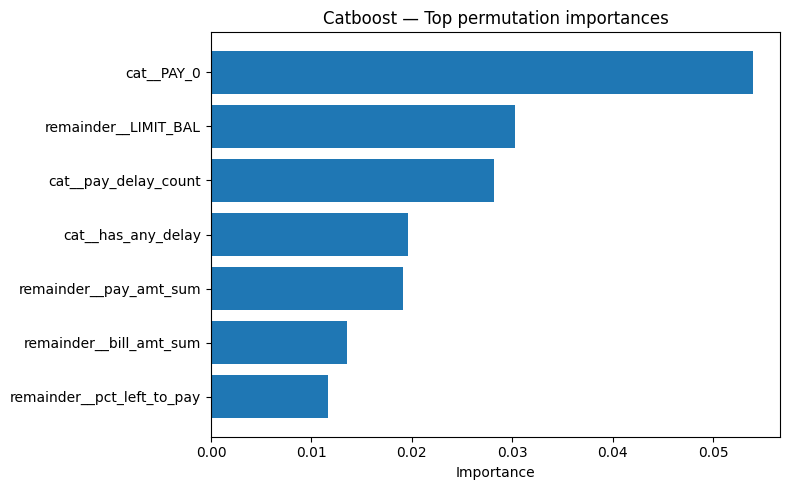

In [24]:
import shap
from sklearn import config_context
from sklearn.inspection import permutation_importance

# SHAP importance
with config_context(transform_output="pandas"):
    Xtr_proc = pipe_fi.named_steps["preprocess"].transform(
        X_train
    )
    Xte_proc = pipe_fi.named_steps["preprocess"].transform(X_test)

feat_names = Xtr_proc.columns.tolist()

# CatBoost TreeExplainer
model = pipe_fi.named_steps["model"]
explainer = shap.TreeExplainer(model)

background = Xtr_proc.sample(n=min(500, len(Xtr_proc)), random_state=SEED)
sh_values = explainer(Xte_proc, check_additivity=False)
sh_values.feature_names = feat_names
shap.summary_plot(sh_values.values, Xte_proc, feature_names=feat_names, rng=SEED)
shap.plots.waterfall(sh_values[0], max_display=15)

# permutation importance
perm = permutation_importance(
    pipe_fi.named_steps["model"],
    Xte_proc,
    y_test,
    n_repeats=10,
    random_state=SEED,
    n_jobs=-1,
    scoring="roc_auc",
)

perm_df = (
    pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(8, 5))
topk_perm = perm_df.head(15).iloc[::-1]
plt.barh(topk_perm["feature"], topk_perm["importance"])
plt.title("Catboost — Top permutation importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### **Answer question 1.b**:
The strongest signals come from **PAY_0**, **pay_delay_count**, and **LIMIT_BAL**. SHAP also places **has_any_delay** near the top, while permutation ranks it slightly lower. On the **lower end, pct_left_to_pay** and **bill_amt_sum** contribute less. Overall, the **aggregate delay/payment features** remain highly informative, and **PAY_0** plus **LIMIT_BAL** continue to show strong predictive power. Together these 7 features carry the majority of the importance among all features available.

### 8. Store serialized model

Now we serialize the model and store it so we can use in our API.

In [25]:
from pathlib import Path
import cloudpickle
import json, sys, time, sklearn

MODELS_DIR = Path.cwd().resolve().parent / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODELS_DIR / "cat_model_v1.0.0.pkl"
METADATA_PATH = MODELS_DIR / "cat_model_v1.0.0_metadata.json"
SIGNATURE_PATH = MODELS_DIR / "cat_model_v1.0.0_input_signature.json"

# Save the calibrated model
with MODEL_PATH.open("wb") as f:
    cloudpickle.dump(calibrated, f)

# Input signature + serving info
signature = {
    "target_name": "default",
    "id_name": "ID",
    "expected_columns": list(X_train.columns),
    "dtypes": {c: str(X_train[c].dtype) for c in X_train.columns},
}

metadata = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "python": sys.version.split()[0],
    "sklearn": sklearn.__version__,
    "model": "Catboost (AGG ONLY, fixes) + Isotonic calibration (cv=5)",
    "threshold": best_thr,
    "test_metrics": metrics,
}

with SIGNATURE_PATH.open("w", encoding="utf-8") as f:
    json.dump(signature, f, indent=2)

with METADATA_PATH.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"\nStored model in: {MODEL_PATH.relative_to(MODELS_DIR.parent)}")
print(f"Stored metadata in: {METADATA_PATH.relative_to(MODELS_DIR.parent)}")
print(f"Stored signature in: {SIGNATURE_PATH.relative_to(MODELS_DIR.parent)}")


Stored model in: models\cat_model_v1.0.0.pkl
Stored metadata in: models\cat_model_v1.0.0_metadata.json
Stored signature in: models\cat_model_v1.0.0_input_signature.json


### 9. Future Improvements

Here are some modifications that can be further explored to improve this notebook:

* **Testing other models and preprocessing techniques**: As I mentioned testing models like Neural Networks and changing the preprocessing pipeline could improve our results.
* **Fine tunning**: Fine-tunning of the models experimented could also improve our metrics by a good margin.
* **More engineered features**: Since our engineered features proved to be very important, we could try adding even more. A good start would be adding columns like max, mean, min of the monetary columns.
* **Cost-based threshold**: Instead of using f1-score as a threshold for calibration, we could set a cost for False Negatives and False Positives in a way to reduce the amount of money lost.
* **Schema guardrail**: Add another transformer to this Pipeline to handle unkown classes and null values. This could prevent many errors in our API.
